In [3]:
# Importing necessary libraries for training and visualization
import numpy as np
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader


%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [5]:
n_samples = 100

train_set = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))


idx = np.append(np.where(train_set.targets == 0)[0][:n_samples], 
                np.where(train_set.targets == 1)[0][:n_samples])

idx=np.append(idx, np.where(train_set.targets==2)[0][:n_samples])
idx=np.append(idx, np.where(train_set.targets==3)[0][:n_samples])

train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

In [6]:
n_samples = 50

test_set = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(test_set.targets == 0)[0][:n_samples], 
                np.where(test_set.targets == 1)[0][:n_samples])
idx=np.append(idx, np.where(test_set.targets==2)[0][:n_samples])
idx=np.append(idx, np.where(test_set.targets==3)[0][:n_samples])

test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [7]:
mean = (0.5,)
std_dev = (0.5,)

normalization_transforms = [transforms.ToTensor(), 
                            transforms.Normalize(mean, std_dev)]


transform = transforms.Compose(normalization_transforms)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1=nn.Linear
        self.fc1 = nn.Linear(256, 64)
        
        self.fc2 = nn.Linear(64, 4)
    

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = self.dropout(x)
        x = x.view(1, -1)
      
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

In [9]:
net=Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [10]:
num_epochs = 20

loss_tracker = []

for epoch in range(num_epochs):
  # Initialize random value for loss just for displaying purposes

  # Using the tqdm for nice training visuals
  progress_bar = tqdm(train_loader, ncols=1000)

  # We load a batch of images and their corresponding labels here and continue
  # until we trained on all batches.
  for i, (images, labels) in enumerate(progress_bar):
    # Convert torch tensor to a vector of size 784 in order to send it to input
    # layer
    images = Variable(images)
    labels = Variable(labels)

    # Clear the gradients before performing backpropagation
    optimizer.zero_grad()
    # Perform the forward pass - this call of net calls the forward() fn
    outputs = net(images)
    # Compute loss on the output of the forward pass and desired label
    loss = criterion(outputs, labels)
    # Compute the gradients with respect to the loss function
    loss.backward()      
    # Update the weights in the neural network using the optimizer/backprop
    optimizer.step()

    # Track losses for plotting later
    loss_tracker.append(loss.data)   

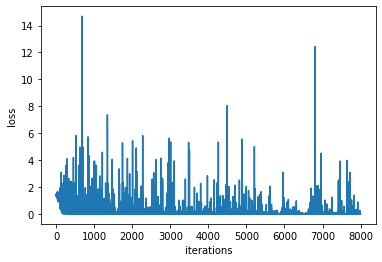

In [11]:
plt.plot(loss_tracker)                               
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

In [12]:
correct=0 
total_loss=[]
    
progress_bar = tqdm(test_loader, ncols=1000)

  # We load a batch of images and their corresponding labels here and continue
  # until we trained on all batches.
with torch.no_grad():
    for i, (images, labels) in enumerate(progress_bar):
    # Convert torch tensor to a vector of size 784 in order to send it to input
    # layer
        images = Variable(images)
        labels = Variable(labels)
    
        outputs = net(images)
        pred = torch.argmax(outputs, dim=1) 

    
        loss = criterion(outputs, labels)
        total_loss.append(loss.item())
    
        correct+= torch.sum(pred==labels).float()



In [13]:
    
print("The recorded accuracies are:\n Accuracy: {:.4f}\nLoss: {:.4f}".format(correct/len(test_set), sum(total_loss)/len(total_loss)))


The recorded accuracies are:
 Accuracy: 0.9800
Loss: 0.0406


In [11]:
PATH="model_dict.pt"
torch.save(net.state_dict(), PATH)